In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from scipy import signal

/home/fernando/anaconda3/envs/SYDE_671/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and process data

In [2]:
# col_headers = np.load('../data/training_data/headers.npy')

x_train = np.load('data/training_data/x_train.npy').astype('float32')
x_val = np.load('data/val_data/x_val.npy').astype('float32')
x_test = np.load('data/test_data/x_test.npy').astype('float32')

y_train = np.load('data/training_data/y_train.npy').astype('float32')
y_val = np.load('data/val_data/y_val.npy').astype('float32')
y_test = np.load('data/test_data/y_test.npy').astype('float32')

In [3]:
# col_headers

array(['RTA', 'LTA', 'IO', 'ECG', 'RGS', 'acc_x_shank', 'acc_y_shank',
       'acc_z_shank', 'gyro_x_shank', 'gyro_y_shank', 'gyro_z_shank',
       'acc_x_shank', 'acc_y_shank', 'acc_z_shank', 'gyro_x_shank',
       'gyro_y_shank', 'gyro_z_shank', 'label'], dtype='<U12')

In [3]:
feature_means = []
feature_stds = []

for feature_i in range(x_train.shape[2]):
    mean = x_train[:, :, feature_i].mean()
    std = x_train[:, :, feature_i].std()
    
    feature_means.append(mean)
    feature_stds.append(std)
    
    x_train[:, :, feature_i] -= mean
    x_train[:, :, feature_i] /= std
    
    x_val[:, :, feature_i] -= mean
    x_val[:, :, feature_i] /= std
    
    x_test[:, :, feature_i] -= mean
    x_test[:, :, feature_i] /= std

## Dataloader

In [5]:
class FOGDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.x = data_x
        self.y = data_y
        
        self.length = self.x.shape[0]
    
    def __getitem__(self, idx):
        x = torch.tensor(self.x[idx, :, :])
        y = torch.tensor(self.y[idx])
        
        return x, y
    
    def __len__(self):
        return self.length

In [6]:
train_dataset = FOGDataset(x_train, y_train)
val_dataset = FOGDataset(x_val, y_val)
test_dataset = FOGDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10)
test_loader = DataLoader(test_dataset, batch_size=10)

## Model

## Training loop

In [8]:



from U_net import UNet
model = UNet()
# model = CNN(17, 0)
model.to(model.device)

torch.manual_seed(0)
np.random.seed(0)

n_epochs = 20
for epoch in range(n_epochs):
    train_losses = []
    model.train()
    
    # Training
    for x, y in tqdm(train_loader):
        x = x.to(model.device)
        y = y.to(model.device)
        
        model.optimizer.zero_grad()
        y_hat = model(x)
        loss = model.loss_fn(y_hat, y)
        loss.backward()
        model.optimizer.step()
        
        train_losses.append(loss.item())
        
    val_losses = []
    val_outputs = []
    model.eval()
    
    # Validation
    for x, y in tqdm(val_loader):
        x = x.to(model.device)
        y = y.to(model.device)
        
        with torch.no_grad():
            y_hat = model(x)
            loss = model.loss_fn(y_hat, y)
            y_hat = torch.round(y_hat)
            
            val_losses.append(loss.item())
            val_outputs.append((y_hat == y).float().mean())
        
    print(f'Epoch: {epoch+1}, Train Loss: {np.array(train_losses).mean():.3f}, ' 
          f'Val Loss: {np.array(val_losses).mean():.3f}, '
          f'Val Accuracy: {np.array(val_outputs).mean():.3f}')
    

  0%|          | 0/77 [05:17<?, ?it/s]


RuntimeError: Given groups=17, weight of size [17, 1, 10], expected input[10, 5000, 18] to have 17 channels, but got 5000 channels instead

In [168]:
torch.save(model, 'model')

## Test the model
Show model performance on test dataset and plots

In [162]:
test_outputs = []
targets = []
model.eval()

for x, y in tqdm(test_loader):
    x = x.to(model.device)
    y = y.to(model.device)

    with torch.no_grad():
        y_hat = model(x)
        y_hat = torch.round(y_hat)
        
        #test_outputs.append(y_hat)
        targets.append(y)
        test_outputs.append((y_hat == y).float().mean())
        

"""sos = signal.butter(1, 1, 'lp', fs=5, output='sos')
test_outputs = torch.cat(test_outputs, dim=0).numpy()
targets = torch.cat(targets, dim=0).numpy()
test_outputs = signal.sosfilt(sos, test_outputs)
"""
print(f'Test Accuracy: {np.array(test_outputs).mean():.3f}')

100%|██████████| 27/27 [00:00<00:00, 76.32it/s]

Test Accuracy: 0.759


In [108]:
(test_outputs == targets).mean()

0.6044474940334129

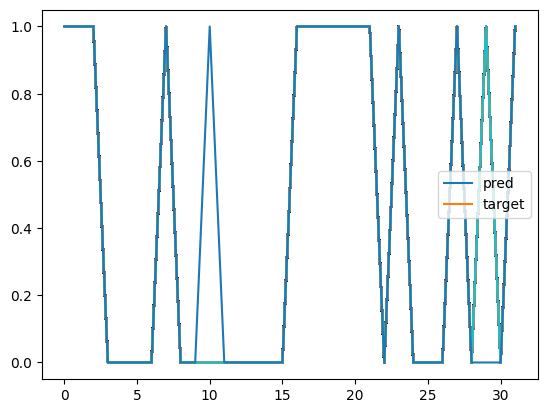

In [157]:
plt.plot(test_outputs[10])
plt.plot(targets[10])
plt.legend(['pred', 'target'])

In [158]:
# Build plots
ys = None
y_hats = None

for i, (x, y) in enumerate(test_loader):
    # Only collect 1 samples
    if i == 1:
        break
        
    with torch.no_grad():
        y_hat = model(x)
        y_hat = torch.round(y_hat)
        
    if ys is None:
        ys = y.view(-1)
        y_hats = y_hat.view(-1)
    else:
        ys = torch.cat([ys, y.view(-1)], dim=0)
        y_hats = torch.cat([y_hats, y_hat.view(-1)], dim=0)

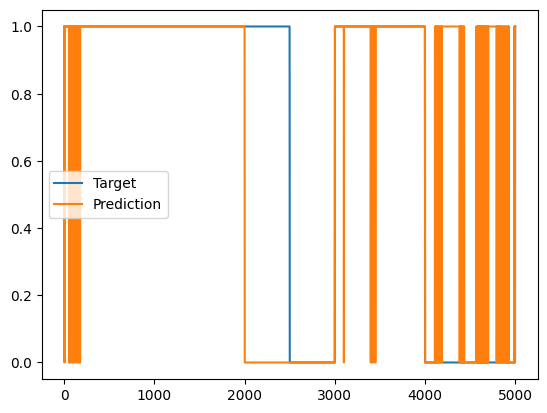

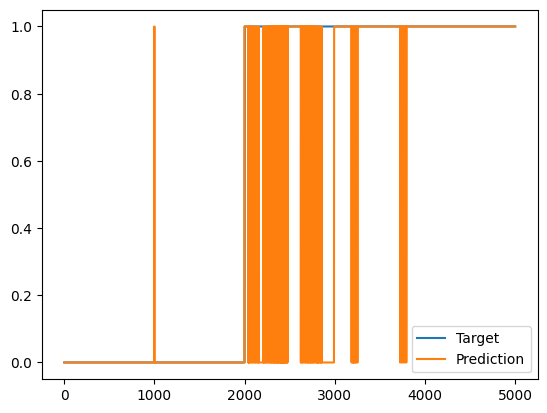

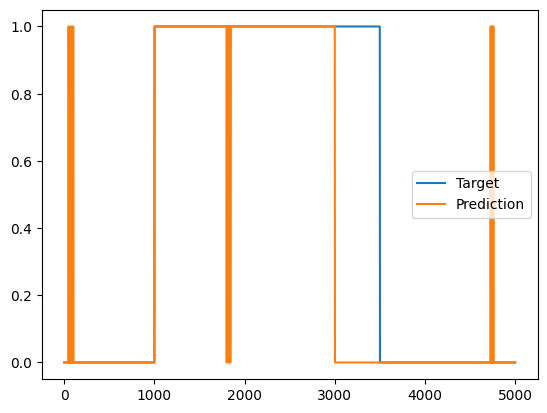

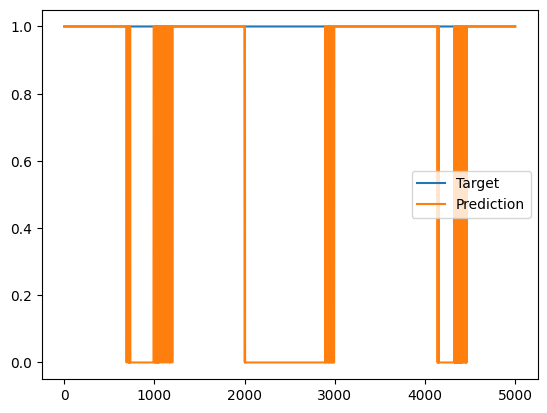

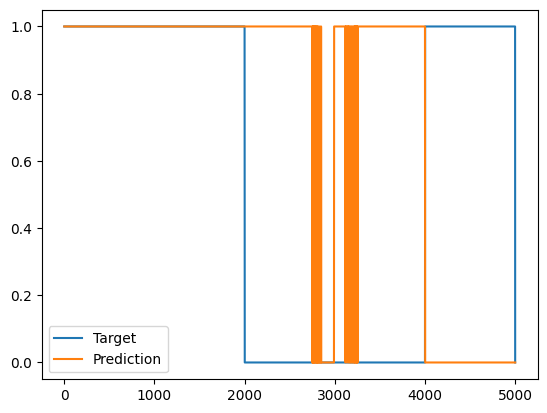

In [159]:
plot_window_size=5000
for i in range(5):
    plt.figure()
    plt.plot(ys[plot_window_size*i:plot_window_size*i+plot_window_size])
    plt.plot(y_hats[plot_window_size*i:plot_window_size*i+plot_window_size])
    plt.legend(['Target', 'Prediction'])